# Data Augmentation

In [1]:
# Get optimal composite values
import pandas as pd

df = pd.read_csv("../reports/reducer_composites.csv")
metric = "Root Mean Squared Error"

optimal_idx = df.groupby("Reducer")[metric].idxmin()
optimal_df = df.loc[optimal_idx]
optimal_df = optimal_df.set_index("Reducer")

reducers = [
    "median",
    "mean",
    "mode",
    "min",
    "max",
    "sampleVariance",
    "kendallsCorrelation",
    "skew",
    "kurtosis",
]

optimal_df = optimal_df.loc[reducers]
composite_dict = optimal_df["Composites"].to_dict()

composite_dict

{'median': 10,
 'mean': 11,
 'mode': 12,
 'min': 12,
 'max': 12,
 'sampleVariance': 2,
 'kendallsCorrelation': 3,
 'skew': 1,
 'kurtosis': 5}

In [2]:
# List the optimal bands
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance(
    "../reports/band_importance.csv"
)

sentinel_bands, indices

Initializing Earth Engine API...


(['B9', 'WVP', 'TCI_G'],
 ['BAIM',
  'BCC',
  'BRBA',
  'BWDRVI',
  'GCC',
  'GVMI',
  'MCARI705',
  'MGRVI',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'NBRplus',
  'NDCI',
  'NDDI',
  'NDGI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'VIBI',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'kVARI',
  'mND705',
  'mSR705'])

In [3]:
# Define function to create data for one year
from datetime import datetime
from ltm.data import sentinel_composite, split_band_name
from ltm.features import load_raster, interpolate_data, to_float32, save_raster
from pathlib import Path
from time import sleep
from tqdm.notebook import tqdm

def create_data(year, target_path, data_folder, batch_size=None):
    # Skip if data already exists
    stem = Path(data_folder).stem
    data_path = Path(data_folder) / f"{year}/{stem}.tif"
    if data_path.exists():
        return
    data_path.parent.mkdir(parents=True, exist_ok=True)

    # Create one composite for each reducer
    data_path = str(data_path)
    total_data = pd.DataFrame()
    for reducer, num_composites in tqdm(composite_dict.items(), desc=f'Composites for {year}'):
        composite_path = str(Path(data_folder) / f"{year}/{stem}_{reducer}_{num_composites}.tif")
        while not Path(composite_path).exists():
            try:
                sentinel_composite(
                    target_path,
                    composite_path,
                    time_window=(datetime(year, 4, 1), datetime(year + 1, 4, 1)),
                    num_composites=num_composites,
                    temporal_reducers=[reducer],
                    indices=indices,
                    sentinel_bands=sentinel_bands,
                    batch_size=batch_size,
                )
            except ValueError as e:
                print(e)
                sleep(300)  # sleep for five minutes

        # Combine into one raster
        data = load_raster(composite_path)
        data = interpolate_data(data)
        columns = [column for column in data.columns if split_band_name(column)[1] != "KendallsCorrelation P-Value"]
        data = data[columns]
        data = to_float32(data)
        total_data = pd.concat([total_data, data], axis=1)
    
    # Save the concatenated data
    save_raster(total_data, target_path, data_path)

In [4]:
# Create data for each year
from ltm.features import drop_nan_rows

target_path = "../data/processed/target.tif"
data_folder = "../data/processed/generalization/data/"
years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

for year in tqdm(years, desc='Years'):
    create_data(year, target_path, data_folder)

# Combine all data into one dataframe
print('Combining data...')
total_data = pd.DataFrame()
for year in tqdm(years, desc='Years'):
    stem = Path(data_folder).stem
    data_path = Path(data_folder) / f"{year}/{stem}.tif"
    data = load_raster(str(data_path))
    total_data = pd.concat([total_data, data])

# Create target data
target = load_raster(target_path)
total_target = pd.concat([target] * len(years))

# Drop common rows with NaN values
data, target = drop_nan_rows(total_data, total_target)

Years:   0%|          | 0/7 [00:00<?, ?it/s]

Combining data...


Years:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Train best model on new data of the study area
import dill

df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
best_model = df["Root Mean Squared Error"].idxmin()

with open(f"../models/{best_model}.pkl", "rb") as f:
    model = dill.load(f)

model.fit(data, target)

model

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.34432013037059533,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.055442782481545896, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=8, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=83, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [6]:
# from sklearn.model_selection import cross_validate
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# cv_results = cross_validate(model, data, target, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
# # TODO: better custom CV splitter needed -> separate same pixel completely (7 times)

# cv_results

In [7]:
# print(-cv_results["test_score"].mean())

# raise ValueError("Stop here")

# Hyperparameter Optimization

In [8]:
# import numpy as np
# from sklearn.model_selection import KFold, BaseCrossValidator

# class RepeatedKFold(BaseCrossValidator):
#     def __init__(self, n_splits=5, n_repeats=1, shuffle=False, random_state=None):
#         self.n_splits = n_splits
#         self.n_repeats = n_repeats
#         self.k_fold = KFold(
#             n_splits=n_splits, shuffle=shuffle, random_state=random_state
#         )

#     def split(self, X, y, groups=None):
#         X = np.array(X)
#         y = np.array(y)

#         if y.shape[0] % self.n_repeats != 0:
#             raise ValueError(
#                 "The number of samples should be divisible by n_repeats."
#             )
#         length = y.shape[0] // self.n_repeats
#         for train, test in self.k_fold.split(X[:length], y[:length]):
#             repeated_train = np.concatenate(
#                 [train + i * length for i in range(self.n_repeats)]
#             )
#             repeated_test = np.concatenate(
#                 [test + i * length for i in range(self.n_repeats)]
#             )

#             yield repeated_train, repeated_test

#     def get_n_splits(self, X = None, y = None, groups = None):
#         return self.n_splits

# cv = RepeatedKFold(n_splits=5, n_repeats=len(years), shuffle=True, random_state=42)

In [9]:
# from sklearn.model_selection import cross_validate

# cv_results = cross_validate(model, data, target, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)

# print(cv_results["test_score"].mean())  # 0.2828385271167998
# # tuned ELM has 0.280xxx Cross Validation Score
# cv_results

In [10]:
# # Create save folder and wrapper functions
# from pathlib import Path
# from sklearn.metrics import make_scorer, root_mean_squared_error

# save_folder = "./"
# Path(save_folder).mkdir(parents=True, exist_ok=True)

# # Define the metric
# rmse_scorer = make_scorer(
#     root_mean_squared_error, greater_is_better=False
# )


# def suggest_categorical(*args, **kwargs):
#     return "suggest_categorical", args, kwargs


# def suggest_discrete_uniform(*args, **kwargs):
#     return "suggest_discrete_uniform", args, kwargs


# def suggest_float(*args, **kwargs):
#     return "suggest_float", args, kwargs


# def suggest_int(*args, **kwargs):
#     return "suggest_int", args, kwargs

In [11]:
# from skelm import ELMRegressor
# from ltm.models import hyperparam_search

# elm_default = ELMRegressor(random_state=42)
# search_space = [
#     suggest_float("alpha", 1e-8, 1e5, log=True),
#     suggest_categorical("include_original_features", [True, False]),
#     suggest_float("n_neurons", 1, 1000),
#     suggest_categorical("ufunc", ["tanh", "sigm", "relu", "lin"]),
#     suggest_float("density", 0.01, 0.99),
# ]

# elm_model, elm_study = hyperparam_search(
#     elm_default,
#     search_space,
#     data,
#     target,
#     rmse_scorer,
#     cv=cv,
#     n_trials=500,
#     save_folder=save_folder,
#     random_state=42,
# )
# elm_model

# Cross-val predict on seen data

# Prediction on unseen data

In [12]:
# Create empty target raster from shape with NaN outside of shape
from ltm.data import shapefile2raster
from pathlib import Path

shapefile_path = "../data/raw/Peterfecking/Peterfecking.shp"
target_path = f"../data/processed/generalization/Peterfecking.tif"
year = 2023
batch_size = 100  # 25 for Freisinger Forst, 100 for Peterfecking, 200 for Traunstein

Path(target_path).parent.mkdir(parents=True, exist_ok=True)
if not Path(target_path).exists():
    shapefile2raster(
        target_path,
        shapefile_path,
    )

In [13]:
# Create data for the target area
stem = Path(target_path).stem
data_folder = str(Path(target_path).parent / stem)
create_data(year, target_path, data_folder, batch_size=batch_size)

In [14]:
# Predict on new data
data_path = str(Path(data_folder) / f"{year}/{stem}.tif")
data = load_raster(data_path)

xgb_pred = model.predict(data)

In [15]:
# Save the prediction by overwriting the shape raster
import numpy as np
import rasterio

with rasterio.open(target_path) as src:
    profile = src.profile
    shape = src.read().shape
    nan_mask = np.isnan(src.read())

xgb_reshaped = xgb_pred.reshape(shape)

with rasterio.open(target_path, "w", **profile) as dst:
    xgb_reshaped[nan_mask] = np.nan
    dst.write(xgb_reshaped)

In [16]:
# Use science style
import matplotlib.pyplot as plt
import scienceplots
%config InlineBackend.figure_format = 'svg'

plt.style.use("science")

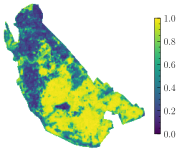

In [17]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

norm = Normalize(vmin=0, vmax=1)
plt.imshow(xgb_reshaped.transpose(1, 2, 0), cmap="viridis", norm=norm, interpolation="nearest")
plt.colorbar(shrink=0.8)
plt.axis("off")

plt.show()

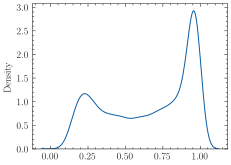

In [18]:
import numpy as np

# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates

ax = sns.kdeplot(xgb_reshaped.flatten())

plt.show()